In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Set logging level to INFO
logging.basicConfig(level=logging.INFO)

In [4]:
class Message:
    '''Class to keep sender, timestamp, public (To/Cc) and hidden (Bcc) recipients of a message
    
    Must map the Message class fields in parseMaildir.py for deserialization purposes
    '''
    def __init__(self, From, mtime, To, Cc, Bcc):
        self.From = From
        self.mtime = mtime
        self.To = To
        self.Cc = Cc
        self.Bcc = Bcc

In [5]:
# Parse the pickle files generated by parseMaildir.py
parsed_logs_folder = 'Enron/parsing/'
social_graph = pickle.load(open(parsed_logs_folder + "social.pkl", "rb"))
log = pickle.load(open(parsed_logs_folder + "replay_log.pkl", "rb"))

In [6]:
def make_global_graph(log):
    '''Construct a global social graph using the log of all emails'''
    global_graph = {}
    global_userset = set()
    
    for email in log:
        if email.From not in global_userset:
            global_userset.add(email.From)
            global_graph[email.From] = {'friends': set()}
            
        recipients = email.To | email.Cc | email.Bcc - {email.From}
        for recipient in recipients:
            global_graph[email.From]['friends'].add(recipient)

    return global_graph, global_userset

In [7]:
def prep_static_view(social_graph):
    '''Prepare the `userset` and `head_dict` structs for the static view scenario
    
    In the static view scenario, all users update their encryption key at the beginning of time.
    We then simulate how the updated keys get propagated after replaying all messages in
    chronological order. We instantiate the `userset` and `head_dict` structs as follows:
    
      * We include in `userset` the users that we have full access to their sent messages
      * We boostrap the social graph of each user in the userset with her future recipients
      * We create a `head_dict` struct to keep track of the latest known head of a user's friends
    '''
    # Set of the dataset users we know the full social graph for
    userset = set()
    
    # Initial state of the global social graph
    head_dict = {}

    for user, info in social_graph.items():
        userset.add(user)
        head_dict[(user, user)] = 1
        for friend in info['friends']:
            head_dict[(user, friend)] = 0

    # Initialize the latest known head dictionary
    for email in log:
        head_dict[(email.From, email.From)] = 1
        
        recipients = email.To | email.Cc | email.Bcc - {email.From}
        for recipient in recipients:
            head_dict[(email.From, recipient)] = 0

    return userset, head_dict

In [8]:
def eval_head_propagation(head_dict, social_graph, userset):
    '''Given `head_dict`, count how many entries for the friends of
    the userset users are up-to-date, stale, or not updated at all'''
    updated = 0
    stale = 0
    not_updated = 0
    
    for user in userset:
        for friend in social_graph[user]['friends']:
            # If entry value is 0, then user did not learn of her friend's updates
            if head_dict[(user, friend)] == 0:
                not_updated += 1
                continue

            # If the friend is not included in the userset, and value is greater than 0,
            # user knows of the head update at the beginning of time
            if (friend, friend) not in head_dict:
                updated += 1
            # Else if friend is included in the userset, we check whether the user knows
            # of her friend's latest head, or an older, stale head
            else:
                if head_dict[(user, friend)] == head_dict[(friend, friend)]:
                    updated += 1
                else:
                    stale += 1

    return updated, stale, not_updated

Simulating the static view scenario of Autocrypt:
Userset users know of 8496 updates of their friends, while 13659 entries were not updated.
50293 out of the 95615 emails sent by users in the userset were encrypted.


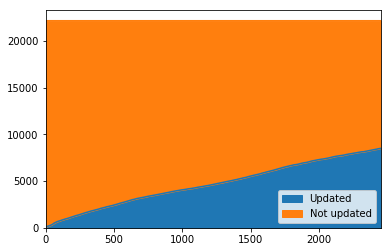

In [9]:
'''Simulate static view of Autocrypt

* Public and private recipients learn of the sender's latest head
'''
print("Simulating the static view scenario of Autocrypt:")

userset, head_dict = prep_static_view(social_graph)

enc_emails = 0
total_sent_emails = 0

cnt = 0
df = pd.DataFrame(columns=('Updated', 'Not updated'))

for email in log:
    recipients = email.To | email.Cc | email.Bcc - {email.From}
    
    # Count how many emails were sent by users in the userset,
    # and how many of those were encrypted
    if email.From in userset:
        total_sent_emails += 1
        enc_emails += 1

        for recipient in recipients:
            try:
                # If sender does not know of a recipient's head, the email is
                # sent in clear text
                if head_dict[(email.From, recipient)] == 0:
                    raise
            except:
                enc_emails -= 1
                break
    
    # For all recipients, update their dict entry for the sender
    for recipient in recipients:
        if email.From in userset:
            latest_head = head_dict[email.From, email.From]
        else:
            latest_head = 1
        head_dict[(recipient, email.From)] = latest_head
    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_head_propagation(head_dict, social_graph, userset)
        df.loc[cnt / 100] = [updated + stale, not_updated]

    cnt += 1
    
updated, stale, not_updated = eval_head_propagation(head_dict, social_graph, userset)
print("Userset users know of %s updates of their friends, while %s entries were not updated."
      % (updated + stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_emails, total_sent_emails))

df.plot.area();

Simulating the static view scenario of ClaimChain with public claims:
Userset users know of 12781 updates of their friends, while 9374 entries were not updated.
61969 out of the 95615 emails sent by users in the userset were encrypted.


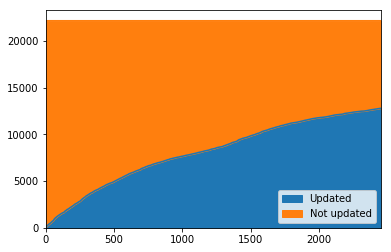

In [10]:
'''Simulate static view of ClaimChain without privacy (providers mode)

* Public and private recipients learn of the sender's latest head
* Public and private recipients learn of the latest head of the friends of the sender
'''
print("Simulating the static view scenario of ClaimChain with public claims:")

userset, head_dict = prep_static_view(social_graph)
global_graph, global_userset = make_global_graph(log)

enc_emails = 0
total_sent_emails = 0

cnt = 0
df = pd.DataFrame(columns=('Updated', 'Not updated'))

for email in log:
    recipients = email.To | email.Cc | email.Bcc - {email.From}
    
    # Count how many emails were sent by users in the userset,
    # and how many of those were encrypted
    if email.From in userset:
        total_sent_emails += 1
        enc_emails += 1

        for recipient in recipients:
            try:
                # If sender does not know of a recipient's head, the email is
                # sent in clear text
                if head_dict[(email.From, recipient)] == 0:
                    raise
            except:
                enc_emails -= 1
                break
    
    # For all recipients, update their dict entry for the sender
    for recipient in recipients:
        if email.From in userset:
            latest_head = head_dict[email.From, email.From]
        else:
            latest_head = 1
        head_dict[(recipient, email.From)] = latest_head
    
    # Update the social graph entries of the recipients for their friends, if the sender
    # knows of a later head
    for recipient in recipients:
        if recipient in global_graph:
            for friend in global_graph[recipient]['friends']:
                try:
                    if head_dict[(recipient, friend)] < head_dict[(email.From, friend)]:
                        head_dict[(recipient, friend)] = head_dict[(email.From, friend)]
                except:
                    continue
                    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_head_propagation(head_dict, social_graph, userset)
        df.loc[cnt / 100] = [updated + stale, not_updated]

    cnt += 1
        

updated, stale, not_updated = eval_head_propagation(head_dict, social_graph, userset)
print("Userset users know of %s updates of their friends, while %s entries were not updated."
      % (updated + stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_emails, total_sent_emails))

df.plot.area();

Simulating the static view scenario of ClaimChain with private claims and introductions:
Userset users know of 8808 updates of their friends, while 13347 entries were not updated.
51738 out of the 95615 emails sent by users in the userset were encrypted.


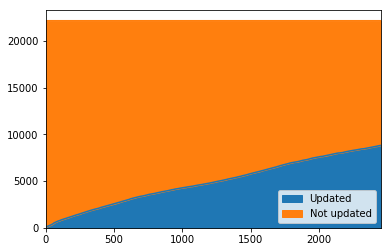

In [11]:
'''Simulate static view of ClaimChain with support for private claims (introduction mode)

* Public and private recipients learn of the sender's latest head
* Sender grants access to public and private recipients to read the entries of public recipients in her ClaimChain
* Recipients learn of the latest head of the friends of the sender that have the capability to access
'''
print("Simulating the static view scenario of ClaimChain with private claims and introductions:")

userset, head_dict = prep_static_view(social_graph)
introductions = {}

enc_emails = 0
total_sent_emails = 0

cnt = 0
df = pd.DataFrame(columns=('Updated', 'Not updated'))

for email in log:
    public_recipients = email.To | email.Cc - {email.From}
    recipients = public_recipients | email.Bcc - {email.From}
    
    # Count how many emails were sent by users in the userset,
    # and how many of those were encrypted
    if email.From in userset:
        total_sent_emails += 1
        enc_emails += 1

        for recipient in recipients:
            try:
                # If sender does not know of a recipient's head, the email is
                # sent in clear text
                if head_dict[(email.From, recipient)] == 0:
                    raise
            except:
                enc_emails -= 1
                break
    
    # Update introductions
    if email.From not in introductions:
        introductions[email.From] = {}

    for recipient in recipients:
        if recipient not in introductions[email.From]:
                introductions[email.From][recipient] = set([])
        for public_recipient in public_recipients:
            introductions[email.From][recipient].add(public_recipient)            
    
    # For all recipients, update their dict entry for the sender
    for recipient in recipients:
        if email.From in userset:
            latest_head = head_dict[email.From, email.From]
        else:
            latest_head = 1
        head_dict[(recipient, email.From)] = latest_head
    
    # Update the social graph entries of the recipients for their friends, if the sender
    # knows of a later head and they have access to it
    for recipient in recipients:
        if recipient in introductions[email.From]:
            for friend in introductions[email.From][recipient]:
                try:
                    if head_dict[(recipient, friend)] < head_dict[(email.From, friend)]:
                        head_dict[(recipient, friend)] = head_dict[(email.From, friend)]
                except:
                    continue
    
    if cnt % 100 == 0:
        updated, stale, not_updated = eval_head_propagation(head_dict, social_graph, userset)
        df.loc[cnt / 100] = [updated + stale, not_updated]

    cnt += 1
        

updated, stale, not_updated = eval_head_propagation(head_dict, social_graph, userset)
print("Userset users know of %s updates of their friends, while %s entries were not updated."
      % (updated + stale, not_updated))
print("%s out of the %s emails sent by users in the userset were encrypted." % (enc_emails, total_sent_emails))

df.plot.area();